## local autoreject before ICA, an ICA file is saved at the end and some visualization plots can be selected to check rejecting rate
* ICA file: to select the components


In [25]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
ICA fitting on Enrico data using MNE
===============================================

This is a parallel process of preprocessing, the goal is to store two sets of ica component images and generate an exclude dict from that: 
        1)reject all the bad data and the bad electrodes in good data
        2)use 1-100Hz band-pass and 50Hz notch filter 
        3)do epochs in order to autoreject bad epochs and observe rejection report
        3)ICA fit and save the ICA components to reject - this is done by using function ica_component_selection()
        ====> output = fif file that save ica object and a rejecting component dict



Note: exploration version

Suggestions:
1) try to decide decim variable to gain precision as well as time
2) 

Updated on June 2019

@author: Gansheng TAN aegean0045@outlook.com, Françoise Lecaignard, francoise.lecaignard@inserm.fr
"""
##############################################################  Set-up ######################################################################

import mne
import importlib
import numpy as np
import os
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
%matplotlib qt
mne.set_log_level('WARNING')
############## segment event creating #########################
events_998=np.array([512, 0, 998])
for i in np.arange(512*2,574*512,512*2):
    events_998=np.vstack((events_998,np.array([i, 0, 998])))

########################### 
# Variable definition
############################

################ inserm computer #####################################
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
filt_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/'
ica_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/ica_file/'
montage_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
epochs_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/autorejed_epochs_data/'
##################################################################################################

########### local laptop###################################################
# raw_data_path = 'E:/important file/INSERM/data_eeglab/raw_data/'
# filt_data_path = 'E:/important file/INSERM/data_eeglab/filt_data/'
# ica_file_path = 'E:/important file/INSERM/data_eeglab/ica_file/'
# montage_path = "C:/Users/aegea/python/INSERM/raw_data/Biosemi64_MAS_EOG.locs"
############################################################################

subj_list = ['94']
state_list=['FA1']
power_freq_array = [50]
reject_raw_data={'07':['OP1','OP2'], '10':['FA1','VD1','VD2'], '21':['VD1','FA2','VD2'],
                '22':['OP2'], '36':['OP1'], '57':['OP2','FA2'], '82':['FA2','OP2','VD2']}
#example: reject_raw_data={'94':['FA1']}
bad_channel={'94':{'FA1':['Pz']}}
# example: bad_channel = {'94':{'FA1':['FP1','FP2'],{'VD1':['Cz']}} excluded for ICA analysis

############################## Visualisation selection ##############
plot_err_matrix = False
plot_filted_psd = False
plot_epochs_rej_intpl = True
plot_epochs_rejed =False
plot_drop_rate = True
plot_epochs_bfaft_compare = False
plot_chan_hist_thresh = True

############################## epochs parameter ##############################
event_id = {'2sec segment': 998}

############################## autorej and ICA parameters #####################
n_interpolate=np.array([1,2,3,4,5,6,32])
pca_n_comp=0.99
random_state=11 # to reproduce the same result
decim=3
save_ica_file = False
save_rejed_epochs = True
###########################
# preprocess one by one
###########################

###################### import subjects' raw eeglab file ################################################################

for subj in subj_list:
    for state in state_list:
        if subj in reject_raw_data.keys() & state in reject_raw_data[subj]:
            continue
        else:
            raw_fname = raw_data_path + 'subj0'+str(subj)+'_'+state+'_mast.set'
            montage_biosemi=mne.channels.read_montage(montage_path)
            raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')
            events = mne.events_from_annotations(raw)
            events=np.asarray(events[0])
            events = np.array(np.vstack((events_998,events)))
            events=events[events[:,0].argsort()]
            unique,counts = np.unique(events[:,0],return_counts=True)
            events_unique_check=dict(zip(unique,counts))
            
            ################ events check, it is ok that we have two diff events in the same sample
#             for sample_nb in events_unique_check.keys():
#                 if events_unique_check[sample_nb] !=1:
#                     print(sample_nb)
#                     print(events_unique_check[sample_nb])
#             print("events nb unique check is done")
       
            
            ############## note bad channels #############################################################################
            raw.info['bads']=bad_channel[subj][state]
            
            ############## filter 1-100Hz and notch 50 ##################################################################
            raw_filt = raw.notch_filter(freqs=power_freq_array)
            raw_filt = raw_filt.filter(l_freq=1,h_freq=100)
            if plot_filted_psd == True:
                raw_filt.plot_psd()  #check filter

            
            ############## do epochs #####################################################################################
            epochs=mne.Epochs(raw_filt,events=events, event_id = event_id, tmin=-1, tmax=1,preload=True)
            
            ############## Auto rejection - local threshold ###############################################################
            picks = mne.pick_types(epochs.info, meg=False, eeg=True, stim=False,
                       eog=False)
            ar = AutoReject(picks=picks, n_interpolate=n_interpolate, random_state=random_state,verbose='tqdm')
            ar=ar.fit(epochs)
            epochs_clean, reject_log = ar.transform(epochs, return_log=True)
            
            if save_rejed_epochs ==True:
                f_rejed_epochs_out= epochs_autorejed_path + 'subj0'+subj+'_'+state+'_autorejed_epo.fif'
                epochs_clean.save(f_rejed_epochs_out)
            
            ############ Plot selection: ex:Auto rej error matrix ############################################################################
            if plot_err_matrix == True:
                set_matplotlib_defaults(plt, style='seaborn-white')
                loss = ar.loss_['eeg'].mean(axis=-1)  # losses are stored by channel type.

                plt.matshow(loss.T * 1e6, cmap=plt.get_cmap('viridis'))
                plt.xticks(range(len(ar.consensus)), ['%.1f' % c for c in ar.consensus])
                plt.yticks(range(len(ar.n_interpolate)), ar.n_interpolate)

                # Draw rectangle at location of best parameters
                ax = plt.gca()
                idx, jdx = np.unravel_index(loss.argmin(), loss.shape)
                rect = patches.Rectangle((idx - 0.5, jdx - 0.5), 1, 1, linewidth=2,
                                         edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.xaxis.set_ticks_position('bottom')
                plt.xlabel(r'Consensus percentage $\kappa$')
                plt.ylabel(r'Max sensors interpolated $\rho$')
                plt.title('Mean cross validation error (x 1e6)')
                plt.colorbar()
                plt.show()
            
            if plot_epochs_rej_intpl == True:
                reject_log.plot_epochs(epochs)
            if plot_epochs_rejed == True:
                epochs_clean.plot()
            if plot_drop_rate ==True:
                epochs_clean.plot_drop_log()
            if plot_epochs_bfaft_compare == True:
                evoked_clean = epochs_clean.average()
                evoked = epochs.average()
                set_matplotlib_defaults(plt)

                fig, axes = plt.subplots(2, 1, figsize=(6, 6))

                for ax in axes:
                    ax.tick_params(axis='x', which='both', bottom='off', top='off')
                    ax.tick_params(axis='y', which='both', left='off', right='off')
                    
                evoked.plot(exclude=[], axes=axes[0], show=False)
                axes[0].set_title('Before autoreject')
                evoked_clean.plot(exclude=[], axes=axes[1])
                axes[1].set_title('After autoreject')
                plt.tight_layout()
                
            if plot_chan_hist_thresh == True:
                threshes = ar.threshes_
                set_matplotlib_defaults(plt)
                unit = r'fT/cm'
                scaling = 1e13

                plt.figure(figsize=(6, 5))
                plt.tick_params(axis='x', which='both', bottom='off', top='off')
                plt.tick_params(axis='y', which='both', left='off', right='off')

                plt.hist(scaling * np.array(list(threshes.values())), 30,
                         color='g', alpha=0.4)
                plt.xlabel('Threshold (%s)' % unit)
                plt.ylabel('Number of sensors')
                plt.tight_layout()
                plt.show()

            
            ############### ICA fit #######################################################################################
            ica = mne.preprocessing.ICA(n_components=pca_n_comp, method='fastica', random_state=11, max_iter=100)
            ica.fit(epochs[~reject_log.bad_epochs],decim=decim)

            #ica.plot_components(inst=epochs)

            
            ############## save ICA file and then read them in auto-process to reject ICA component ############################
            f_ica = ica_file_path + 'subj0'+subj+'_'+state+'_component_ica.fif'
            if save_ica_file == True:
                ica.save(f_ica)
                print("ICA file successfully saved")
            else:
                print("ICA file not saved")
            

            


Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj094_FA1_mast.fdt
Reading 0 ... 294399  =      0.000 ...   574.998 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

/home/gansheng.tan/mne/local/lib/python3.5/site-packages/autoreject/utils.py:75: UserWarning: 1 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  'remove them from epochs.info["bads"].' % n_bads)
Creating augmented epochs:   0%|          | 0/63 [00:00<?, ?it/s]

Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 63/63 [02:56<00:00,  2.67s/it]


Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   3%|▎         | 10/287 [00:00<00:02, 97.23it/s]

Repairing epochs:   8%|▊         | 23/287 [00:00<00:02, 104.88it/s]

Repairing epochs:  13%|█▎        | 37/287 [00:00<00:02, 111.75it/s]

Repairing epochs:  17%|█▋        | 50/287 [00:00<00:02, 115.91it/s]

Repairing epochs:  22%|██▏       | 64/287 [00:00<00:01, 120.19it/s]

Repairing epochs:  27%|██▋       | 78/287 [00:00<00:01, 123.46it/s]

Repairing epochs:  32%|███▏      | 92/287 [00:00<00:01, 126.79it/s]

Repairing epochs:  38%|███▊      | 110/287 [00:00<00:01, 137.73it/s]

Repairing epochs:  45%|████▍     | 129/287 [00:00<00:01, 148.40it/s]

Repairing epochs:  50%|█████     | 144/287 [00:01<00:01, 135.09it/s]

Repairing epochs:  55%|█████▌    | 158/287 [00:02<00:03, 34.47it/s] 

Repairing epochs:  59%|█████▉    | 170/287 [00:02<00:02, 43.54it/s]

Repairing epochs:  64%|██████▍   |

Repairing epochs:   6%|▌         | 17/287 [00:00<00:07, 37.68it/s]

Repairing epochs:   7%|▋         | 21/287 [00:00<00:07, 36.89it/s]

Repairing epochs:   9%|▊         | 25/287 [00:00<00:07, 36.60it/s]

Repairing epochs:  10%|█         | 29/287 [00:00<00:07, 35.73it/s]

Repairing epochs:  11%|█▏        | 33/287 [00:00<00:07, 35.78it/s]

Repairing epochs:  13%|█▎        | 37/287 [00:01<00:06, 36.24it/s]

Repairing epochs:  15%|█▍        | 42/287 [00:01<00:06, 37.49it/s]

Repairing epochs:  16%|█▌        | 46/287 [00:01<00:06, 37.34it/s]

Repairing epochs:  17%|█▋        | 50/287 [00:01<00:06, 36.36it/s]

Repairing epochs:  19%|█▉        | 54/287 [00:01<00:06, 36.46it/s]

Repairing epochs:  21%|██        | 59/287 [00:01<00:05, 38.03it/s]

Repairing epochs:  22%|██▏       | 64/287 [00:01<00:05, 39.26it/s]

Repairing epochs:  24%|██▍       | 69/287 [00:01<00:05, 39.56it/s]

Repairing epochs:  26%|██▌       | 74/287 [00:01<00:05, 41.75it/s]

Repairing epochs:  28%|██▊       | 79/287 [00:02

Repairing epochs:  54%|█████▎    | 154/287 [00:04<00:03, 36.77it/s]

Repairing epochs:  55%|█████▌    | 158/287 [00:04<00:03, 37.13it/s]

Repairing epochs:  56%|█████▋    | 162/287 [00:04<00:03, 36.34it/s]

Repairing epochs:  58%|█████▊    | 166/287 [00:04<00:03, 35.92it/s]

Repairing epochs:  59%|█████▉    | 170/287 [00:05<00:03, 36.36it/s]

Repairing epochs:  61%|██████    | 174/287 [00:05<00:03, 35.82it/s]

Repairing epochs:  62%|██████▏   | 178/287 [00:05<00:03, 30.90it/s]

Repairing epochs:  63%|██████▎   | 182/287 [00:05<00:03, 30.42it/s]

Repairing epochs:  65%|██████▍   | 186/287 [00:05<00:03, 28.63it/s]

Repairing epochs:  66%|██████▌   | 190/287 [00:05<00:03, 30.91it/s]

Repairing epochs:  68%|██████▊   | 194/287 [00:05<00:02, 32.79it/s]

Repairing epochs:  69%|██████▉   | 198/287 [00:06<00:02, 32.45it/s]

Repairing epochs:  70%|███████   | 202/287 [00:06<00:02, 30.53it/s]

Repairing epochs:  72%|███████▏  | 206/287 [00:06<00:02, 30.42it/s]

Repairing epochs:  73%|███████▎  |

Repairing epochs:  97%|█████████▋| 277/287 [00:07<00:00, 40.45it/s]

Repairing epochs:  98%|█████████▊| 282/287 [00:07<00:00, 41.02it/s]

Repairing epochs: 100%|██████████| 287/287 [00:07<00:00, 39.73it/s]


Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:03<00:34,  3.83s/it]


Fold:  20%|██        | 2/10 [00:07<00:30,  3.87s/it]


Fold:  30%|███       | 3/10 [00:11<00:26,  3.83s/it]


Fold:  40%|████      | 4/10 [00:15<00:22,  3.81s/it]


Fold:  50%|█████     | 5/10 [00:19<00:18,  3.79s/it]


Fold:  60%|██████    | 6/10 [00:22<00:15,  3.79s/it]


Fold:  70%|███████   | 7/10 [00:26<00:11,  3.80s/it]


Fold:  80%|████████  | 8/10 [00:30<00:07,  3.80s/it]


Fold:  90%|█████████ | 9/10 [00:34<00:03,  3.79s/it]


n_interp:  57%|█████▋    | 4/7 [03:11<02:23, 47.87s/it]

Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 2/287 [00:00<00:21, 13.28it/s]

Repairing epochs:   2%|▏         | 5/287 [00:00<00:17, 15.87it/s]



Repairing epochs:  22%|██▏       | 62/287 [00:01<00:06, 36.93it/s]

Repairing epochs:  23%|██▎       | 67/287 [00:02<00:05, 39.17it/s]

Repairing epochs:  25%|██▌       | 72/287 [00:02<00:05, 39.91it/s]

Repairing epochs:  27%|██▋       | 77/287 [00:02<00:05, 40.73it/s]

Repairing epochs:  29%|██▊       | 82/287 [00:02<00:05, 39.33it/s]

Repairing epochs:  30%|███       | 87/287 [00:02<00:04, 40.12it/s]

Repairing epochs:  32%|███▏      | 92/287 [00:02<00:05, 38.62it/s]

Repairing epochs:  33%|███▎      | 96/287 [00:02<00:04, 38.29it/s]

Repairing epochs:  35%|███▌      | 101/287 [00:02<00:04, 39.32it/s]

Repairing epochs:  37%|███▋      | 105/287 [00:03<00:04, 38.03it/s]

Repairing epochs:  39%|███▊      | 111/287 [00:03<00:04, 41.25it/s]

Repairing epochs:  41%|████      | 117/287 [00:03<00:03, 43.78it/s]

Repairing epochs:  43%|████▎     | 122/287 [00:03<00:03, 41.42it/s]

Repairing epochs:  44%|████▍     | 127/287 [00:03<00:03, 40.83it/s]

Repairing epochs:  46%|████▌     | 132/287

Repairing epochs:  71%|███████   | 204/287 [00:05<00:02, 36.29it/s]

Repairing epochs:  72%|███████▏  | 208/287 [00:05<00:02, 36.50it/s]

Repairing epochs:  74%|███████▍  | 212/287 [00:05<00:02, 36.00it/s]

Repairing epochs:  75%|███████▌  | 216/287 [00:05<00:02, 35.46it/s]

Repairing epochs:  77%|███████▋  | 220/287 [00:06<00:01, 35.31it/s]

Repairing epochs:  78%|███████▊  | 224/287 [00:06<00:01, 35.81it/s]

Repairing epochs:  79%|███████▉  | 228/287 [00:06<00:01, 35.88it/s]

Repairing epochs:  81%|████████  | 232/287 [00:06<00:01, 36.12it/s]

Repairing epochs:  83%|████████▎ | 238/287 [00:06<00:01, 39.82it/s]

Repairing epochs:  85%|████████▍ | 243/287 [00:06<00:01, 41.83it/s]

Repairing epochs:  86%|████████▋ | 248/287 [00:06<00:00, 43.69it/s]

Repairing epochs:  88%|████████▊ | 253/287 [00:06<00:00, 40.99it/s]

Repairing epochs:  90%|████████▉ | 258/287 [00:06<00:00, 39.53it/s]

Repairing epochs:  92%|█████████▏| 263/287 [00:07<00:00, 40.09it/s]

Repairing epochs:  93%|█████████▎|





Estimated consensus=1.00 and n_interpolate=32




Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 3/287 [00:00<00:11, 25.06it/s]

Repairing epochs:   2%|▏         | 6/287 [00:00<00:11, 24.97it/s]

Repairing epochs:   3%|▎         | 9/287 [00:00<00:10, 25.85it/s]

Repairing epochs:   5%|▍         | 13/287 [00:00<00:10, 27.34it/s]

Repairing epochs:   6%|▌         | 16/287 [00:00<00:09, 27.89it/s]

Repairing epochs:   7%|▋         | 19/287 [00:00<00:10, 25.66it/s]

Repairing epochs:   8%|▊         | 23/287 [00:00<00:09, 27.45it/s]

Repairing epochs:   9%|▉         | 27/287 [00:00<00:08, 29.53it/s]

Repairing epochs:  11%|█         | 31/287 [00:01<00:08, 31.16it/s]

Repairing epochs:  12%|█▏        | 35/287 [00:01<00:08, 31.29it/s]

Repairing epochs:  14%|█▎        | 39/287 [00:01<00:07, 32.68it/s]

Repairing epochs:  15%|█▍        | 43/287 [00:01<00:07, 33.78it/s]

Repairing epochs:  16%|█▋        | 47/287 [00:01<00:06, 34.66it/s]

Repairing epochs:  18%|█▊        | 51/287 [00:01<00:06, 35

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


/home/gansheng.tan/mne/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


ICA file not saved


 ## visualization function

In [36]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
ICA componont visualisation on Enrico data using MNE
===============================================

This is a parallel process of preprocessing, the goal is to visualize the ICA components and select rejecting ones from them:
        ====> input : ica file for one subject
        1)detect eog components and visualize the correlation
        2)detect other types of artifacts
        3)give out excluding components for each subject
        ====> output = fif file that save ica object and a rejecting component dict


Note: exploration version

Suggestions:
1) can be used as a function to be included in automated process
2) 

Updated on June 2019

@author: Gansheng TAN aegean0045@outlook.com, Françoise Lecaignard, francoise.lecaignard@inserm.fr
"""
##############################################################  Set-up ######################################################################

import mne
import importlib
import numpy as np
import os
from autoreject import AutoReject
from autoreject import get_rejection_threshold 
%matplotlib qt
mne.set_log_level('WARNING')


##########################
# ICA visualisation
##########################

def ica_component_selection(subj,state,HEOG_corr=False, VEOG_corr=True):
    
    
    ########################### 
    # Variable definition
    ############################

    ################ inserm computer #####################################
    raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
    filt_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/'
    ica_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/ica_file/'
    montage_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
    epochs_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/autorejed_epochs_data/'
    ##################################################################################################

    ########### local laptop###################################################
    # raw_data_path = 'E:/important file/INSERM/data_eeglab/raw_data/'
    # filt_data_path = 'E:/important file/INSERM/data_eeglab/filt_data/'
    # ica_file_path = 'E:/important file/INSERM/data_eeglab/ica_file/'
    # montage_path = "C:/Users/aegea/python/INSERM/raw_data/Biosemi64_MAS_EOG.locs"
    ############################################################################
    
    reject_raw_data={'07':['OP1','OP2'], '10':['FA1','VD1','VD2'], '21':['VD1','FA2','VD2'],
                '22':['OP2'], '36':['OP1'], '57':['OP2','FA2'], '82':['FA2','OP2','VD2']}
    #example: reject_raw_data={'94':['FA1']}
    bad_channel={'94':{'FA1':['Pz']}}
    
    ########################### visualization parameters #########################
    
    ###########################
    
    
    
    ###################################### read epochs ##################################################
    
    
    if subj in reject_raw_data.keys() & state in reject_raw_data[subj]:
        print("the recording file is of low quality, we do not do ica on this raw data")
    else:
        
        filename_epochs = epochs_autorejed_path + 'subj0'+subj+'_'+state+'_autorejed_epo.fif'
        montage_biosemi=mne.channels.read_montage(montage_path)
        epochs = mne.read_epochs(filename_epochs,preload=True)
    
        
        f_ica = ica_file_path + 'subj0'+subj+'_'+state+'_component_ica.fif'
        ica = mne.preprocessing.read_ica(f_ica)
    

    
    
        ############### EOG channel verification
        title = 'Sources related to %s artifacts (red)'
        # detect EOG by correlation
        n_max_eog = 1

        if VEOG_corr ==True:
            eog_inds, scores = ica.find_bads_eog(epochs,ch_name='VEOG')
            ica.plot_scores(scores, exclude=eog_inds, title=title % 'Veog', labels='Veog')

            show_picks = np.abs(scores).argsort()[::-1][:5]

            ica.plot_sources(epochs, exclude=eog_inds, title=title % 'Veog')
            ica.plot_components(eog_inds, title=title % 'Veog', colorbar=True)
            eog_inds = eog_inds[:n_max_eog]
            #ica.exclude += eog_inds   add eog artifact in the exclude list.
#             eog_evoked = mne.preprocessing.create_eog_epochs(epochs, tmin=-.5, tmax=.5, picks=picks).average()
#             ica.plot_sources(eog_evoked, exclude=eog_inds)  # plot EOG sources + selection   this plot is to plot ica components
#             ica.plot_overlay(eog_evoked, exclude=eog_inds)  # plot EOG cleaning  this plot is compare channels' signal
#                                                                             #after and before removing eog components

        if HEOG_corr ==True:
            eog_inds, scores = ica.find_bads_eog(epochs,ch_name='HEOG')
            ica.plot_scores(scores, exclude=eog_inds, title=title % 'Heog', labels='Heog')

            show_picks = np.abs(scores).argsort()[::-1][:5]

            ica.plot_sources(epochs, exclude=eog_inds, title=title % 'Heog')
            ica.plot_components(eog_inds, title=title % 'Heog', colorbar=True)
            eog_inds = eog_inds[:n_max_eog]
            #ica.exclude += eog_inds   add eog artifact in the exclude list.

#             eog_evoked = mne.preprocessing.create_eog_epochs(epochs, tmin=-.5, tmax=.5, picks=picks).average()
#             ica.plot_sources(eog_evoked, exclude=eog_inds)  # plot EOG sources + selection   this plot is to plot ica components
#             ica.plot_overlay(eog_evoked, exclude=eog_inds)  # plot EOG cleaning  this plot is compare channels' signal
#                                                                             #after and before removing eog components

        # check the amplitudes do not change
        #ica.plot_overlay(raw_filt)  # EOG artifacts remain # not very useful, we do not gain a lot of info from it
        ica.plot_components(inst=epochs)
        #ica.plot_properties()
        print("select the removing components and fill the ica_selection dict")
    return True



## Selection ICA components

In [37]:
## fill this dict
ica_selection = { '94':[0,9]}

## run this function to see the data
ica_component_selection('94','FA1')

select the removing components and fill the ica_selection dict


True

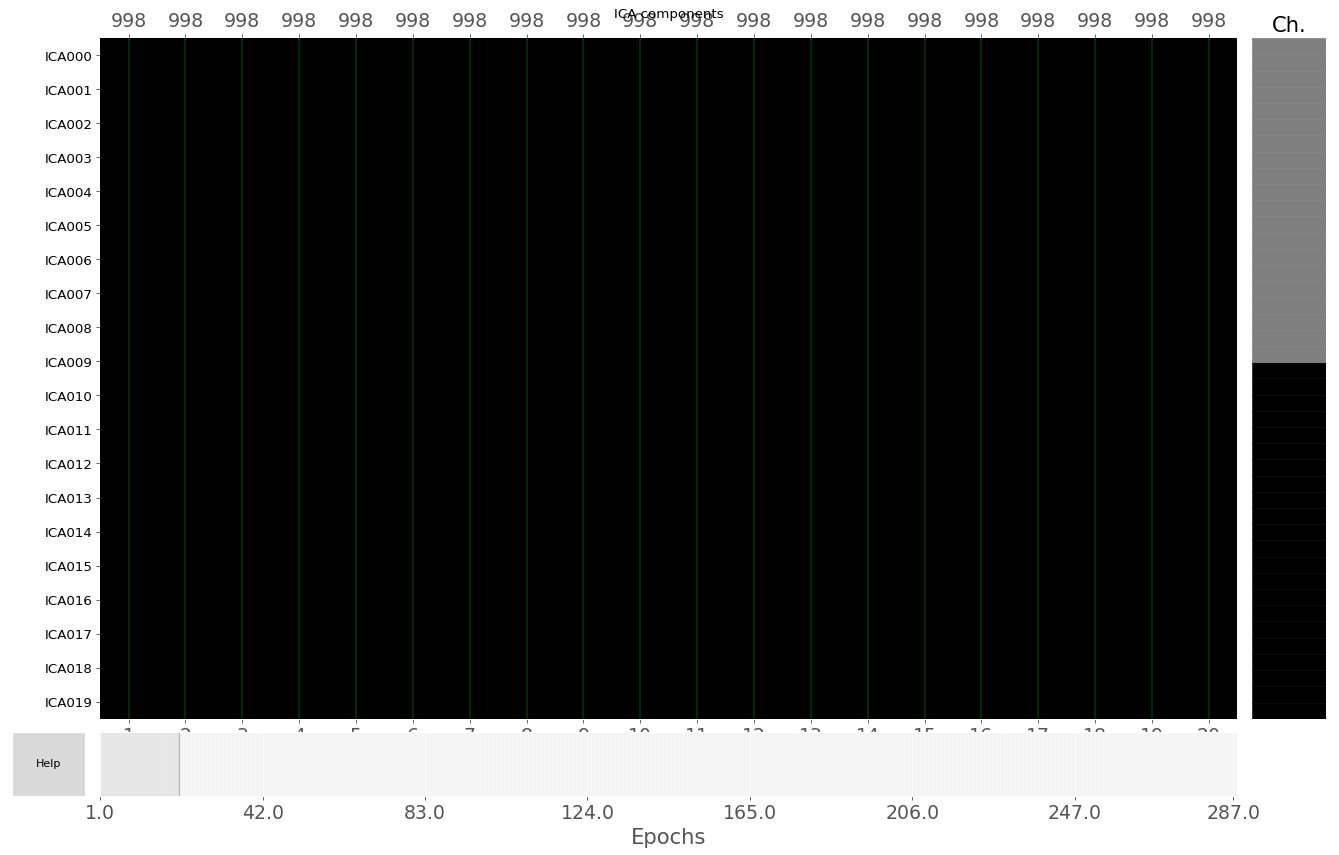

In [56]:
epochs_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/autorejed_epochs_data/'
filename_epochs = epochs_autorejed_path + 'subj0'+subj+'_'+state+'_autorejed_epo.fif'
epochs = mne.read_epochs(filename_epochs,preload=True)
f_ica = ica_file_path + 'subj0'+subj+'_'+state+'_component_ica.fif'
ica = mne.preprocessing.read_ica(f_ica)
ica.plot_sources(epochs)

## Automated process

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
Pre_processing on Enrico data using MNE
===============================================

We firstly define subject dictionary as well as state list, reject dict, then we import eeglab format Raw data with MNE package.  
1) a notch filter to remove powerline artifact (50 Hz)
2) a 0.1Hz high-pass filter
====> output = subj0*number*_*state*_filt_raw.fif  
3) ICA correction : we exclude ICA components accoring to exclue dict
    # parallel process: we do
        1)reject all the bad data and the bad electrodes in good data
        2)use 1-40Hz band-pass filter 
        3)save and select the ICA components to reject
        ====> output =python dictionary aimed to exclude ICA components

    
====> output = format need to be decided

Note: In current stage, this script is developped and tested using one subject in local computer,in order to run it in cluster,
one need to change the raw_data path. Same for states.(we have FA1,FA2,VD1,VD2,OP1,OP2)

Suggestions:
1) use np.arange to generate subject list, do not forget to add 0 for subject number ranging from 1 to 9
2) generate a csv file(or print to console) to summarise how many raw data read and how many 
    raw data is rejected
Updated on June 2019

@author: Gansheng TAN aegean0045@outlook.com, Françoise Lecaignard, francoise.lecaignard@inserm.fr
"""
##############################################################  Set-up ######################################################################

import mne
import importlib
import numpy as np
import os
mne.set_log_level('WARNING')

#################################### step00 import subjects' raw eeglab file ################################################################

########################### 
# Variable definition
############################
################ inserm computer #####################################
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
filt_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/'
ica_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/ica_file/'
montage_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
##################################################################################################

########### local laptop###################################################
# raw_data_path = 'E:/important file/INSERM/data_eeglab/raw_data/'
# filt_data_path = 'E:/important file/INSERM/data_eeglab/filt_data/'
# ica_file_path = 'E:/important file/INSERM/data_eeglab/ica_file/'
# montage_path = "C:/Users/aegea/python/INSERM/raw_data/Biosemi64_MAS_EOG.locs"
############################################################################

subj_list = ['94']
state_list=['FA1']
save_filt = True
power_freq_array = [50]
reject_raw_data={'07':['OP1','OP2'], '10':['FA1','VD1','VD2'], '21':['VD1','FA2','VD2']
                '22':['OP2'], '36':['OP1'], '57':['OP2','FA2'], '82':['FA2','OP2','VD2']}
#example: reject_raw_data={'94':['FA1']}
ica_selection = {'94':[0,7,10,17]}

###########################
# preprocess one by one
###########################
for subj in subj_list:
    for state in state_list:
        if subj in reject_raw_data.keys() & state in reject_raw_data[subj]:
            continue
        else:
            raw_fname = raw_data_path + 'subj0'+subj+'_'+state+'_mast.set'
            montage_biosemi=mne.channels.read_montage(montage_path)
            raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True)
            raw_filt = raw.notch_filter(power_freq_array)
            raw_filt = raw_filt.filter(l_freq=0.1,h_freq=None)
            if save_filt:
                f_raw_filt = filt_data_path+'subj0'+subj+'_'+state+'_filt_raw.fif'
                raw_filt.save(f_raw_filt,overwrite=True)
##########################
# ICA correction
##########################

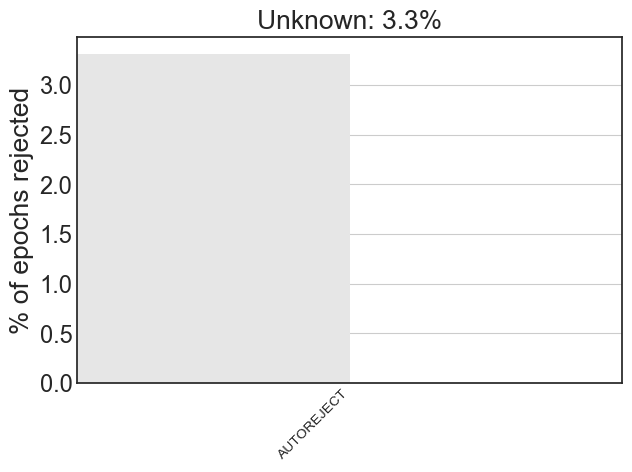

In [34]:
scalings = dict(eeg=40e-6)
#reject_log.plot_epochs(epochs, scalings=scalings)
epochs_clean.plot_drop_log()


In [35]:
ar.threshes_

{'Fp1': 0.00010669652557491834,
 'AF7': 9.542333773150552e-05,
 'AF3': 8.150377116600868e-05,
 'F1': 5.880238682124771e-05,
 'F3': 6.786627599331357e-05,
 'F5': 6.896013891355167e-05,
 'F7': 5.7310935652414384e-05,
 'FT7': 3.998959825535294e-05,
 'FC5': 4.602828024099337e-05,
 'FC3': 5.2932044208567634e-05,
 'FC1': 7.589242899610669e-05,
 'C1': 5.751868635068657e-05,
 'C3': 5.057452034855471e-05,
 'C5': 4.391891013759835e-05,
 'T7': 0.00014889027001985266,
 'TP7': 4.3052970171881376e-05,
 'CP5': 5.579828392895866e-05,
 'CP3': 5.342228299296015e-05,
 'CP1': 5.329112121915712e-05,
 'P1': 6.374809238324183e-05,
 'P3': 5.092120037960432e-05,
 'P5': 5.533227238035455e-05,
 'P7': 4.057112059394285e-05,
 'P9': 0.0001824140135629775,
 'PO7': 7.171389696477177e-05,
 'PO3': 5.930428798362397e-05,
 'O1': 6.843033207146514e-05,
 'Iz': 3.926443891163861e-05,
 'Oz': 4.293578163338031e-05,
 'POz': 6.995990707911437e-05,
 'CPz': 5.7060086972263036e-05,
 'Fpz': 0.0001386743708581332,
 'Fp2': 9.04811743

In [47]:
f_ica = ica_file_path + 'subj0'+subj+'_'+state+'_component_ica.fif'
ica.save(f_ica)

<ICA  |  epochs decomposition, fit (fastica): 49860 samples, 18 components, channels used: "eeg">